## Analysis of the full glycolysis network - Glucose substrate
#### Experiment code : SNMS32

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns; sns.set_theme(style='ticks', context='paper')
import colorcet as cc
import glob

import toml

In [2]:
#Definition of constants
TIMEBIN = 90 #Binning (~45s)

### Isotopic ratios for isotopic correction (15N-Glu, NADH) ###
Glu_13C_isotope = 0.0546 # Percentage of signal of glutamate isotope (146) to remove from 15N-glutamate (147)
NAD_2_13C_isotope = 0.0245 # Percentage of signal of NAD isotope (662) to remove from NADH (664)
Glu_conc_ratio = 0.104429302*0.5 #Ratio of concentrations of glutamate (0.05517 mM) and 15N-glutamate (0.5283 mM)
### !!! In this experiment, half the concentration of glutamate was added !!!
### !!! In this experiment, the concentration of 15N-glutamate was not identical in all syringes !!!
### We will correct for it a dedicated cell


### NMR concentrations ###
F_concentration = 0.09288 # mM
G_concentration = 0.07956 # mM
G6P_concentration = 0.08957 # mM
F6P_concentration = 0.07707 # mM
FBP_concentration = 0.05594 # mM
ATP_concentration = 0.05 # mM
Pyr_concentration = 0.0912 # mM
Lac_concentration = 0.096288 # mM
PG_concentration = 0.088709 # mM
PEP_concentration = 0.09325 # mM

### Frag ratios ###
FBPtoF6P = 0.071
FtoLac = 0.058
GtoLac = 0.038

## Reading the data and conditions

In [3]:
#Reading the conditions
flow_parameters = toml.load("conditions/SNMS32_flowparameters.toml")
inputs = np.array([[c['length'], c['syringe_parameters']['G']['reactor_concentration'], 
                    c['syringe_parameters']['ATP']['reactor_concentration'], 
                    c['syringe_parameters']['ADP']['reactor_concentration'], 
                    c['syringe_parameters']['NAD']['reactor_concentration']] 
                    for c in flow_parameters['sections']
                ])

df_inputs = pd.DataFrame(
        inputs, columns=['time', 'G', 'ATP', 'ADP', 'NAD']
    ).assign(time = np.cumsum(inputs[:,0]))
print(df_inputs)
#correcting the inputs for time in minutes
df_inputgraph = df_inputs.copy()
df_inputgraph['time'] = (df_inputs['time'] / 60) - 90 #in minutes, minus the first 90 minutes of equilibration

       time     G   ATP   ADP  NAD
0       0.0  2.00  1.50  1.50  1.5
1    1800.0  2.00  1.50  1.50  1.5
2    9000.0  2.00  2.25  0.75  1.5
3   12600.0  1.00  2.25  0.75  1.5
4   16200.0  0.50  2.25  0.75  1.5
5   19800.0  0.25  2.25  0.75  1.5
6   23400.0  2.00  0.75  2.25  1.5
7   27000.0  1.00  0.75  2.25  1.5
8   30600.0  0.50  0.75  2.25  1.5
9   34200.0  0.25  0.75  2.25  1.5
10  37800.0  2.00  2.25  0.75  1.0
11  41400.0  1.00  2.25  0.75  1.0
12  45000.0  0.50  2.25  0.75  1.0
13  48600.0  0.25  2.25  0.75  1.0
14  52200.0  2.00  0.75  2.25  1.0
15  55800.0  1.00  0.75  2.25  1.0
16  59400.0  0.50  0.75  2.25  1.0
17  63000.0  0.25  0.75  2.25  1.0


In [4]:
#Reading the data
files = pathlib.Path(f"data/SNMS32/").glob('*.xy')

sumdf = pd.DataFrame()
    
try:
    with open(f"data/SNMS32/TIC.xy",'r') as fin:
        df = pd.read_csv(fin, sep=' ', names=['Time','TIC'])
        df_TICSamp1 = df['Time'].groupby(df.index // TIMEBIN).min()
        df_TICSamp2 = df['TIC'].groupby(df.index // TIMEBIN).sum()
        df_TICSamp = pd.concat([df_TICSamp1,df_TICSamp2], axis=1)
                    
except FileNotFoundError:
    print("No TIC files here!")
    
df_Time = df_TICSamp['Time']

sumdf["retention_time"] = df_Time
        
fileList=glob.glob(f"data/SNMS32/*.xy")
fileList.remove(f"data/SNMS32\\TIC.xy")
    
for file in fileList:
    try:
        with open(file,'r') as fin:
            df_file = pd.read_csv(fin, sep=' ', names=['Time','IC'])

            ionname = pathlib.Path(file).stem
            
            #binning
            df_Samp1 = df_file['Time'].groupby(df_file.index // TIMEBIN).min()
            df_Samp2 = df_file['IC'].groupby(df_file.index // TIMEBIN).sum()
            df_Samp = pd.concat([df_Samp1,df_Samp2], axis=1)

            #TIC corr
            df_SampTIC = df_Samp['IC'] / df_TICSamp['TIC']
            df_SampTIC.name = ionname

            sumdf[ionname] = df_SampTIC
    except FileNotFoundError:
        print("Missing files")

    
sumdf = sumdf.assign(retention_time = sumdf.retention_time.round(1))
sumdf = sumdf.set_index('retention_time')
#print(sumdf)

In [5]:
### Correction for the uneven Glu-15N concentrations in the syringes
#We will divide for the real concentration of Glu-15N fed to the CSTR and multiply by the correct concentration (0.5 mM)

list_conc_L_glu = [0.5575, 0.5575, 0.6825, 0.745, 0.77625, 0.5575, 0.6825, 0.745, 0.77625, 0.5575, 0.6825, 0.745, 0.77625, 0.5575, 0.6825, 0.745, 0.77625]
SSTIMES = df_inputs["time"].tolist()
real_glu_df = pd.DataFrame()
real_glu_df["time"] = sumdf.index
real_glu_df.loc[real_glu_df.index.min(),"L_Glu_conc"] = list_conc_L_glu[0]

i = 1
while i < (len(list_conc_L_glu)):
    conc = list_conc_L_glu[i]
    time = SSTIMES[(i)] + 1200 #offset between timstof and labm8
    real_glu_df.loc[(real_glu_df["time"] - time).abs().argsort()[:2],"L_Glu_conc"] = conc  
    i+=1

real_glu_df.loc[real_glu_df.index.min(),"target_conc"] = 0.5
real_glu_df = real_glu_df.ffill()
real_glu_df["ratio"] = real_glu_df["L_Glu_conc"]/real_glu_df["target_conc"]
real_glu_df.index = sumdf.index 

sumdf["L_Glu_corr"] = (sumdf["L_Glu"] - (Glu_13C_isotope*sumdf["Glu"])) / real_glu_df["ratio"] 
#Correction for both isotope and wrong 15-N-glu concentration

#Calculation of the flow ratios between dilution line and reactor
sumdf["Flow ratio"] = (sumdf["L_Glu_corr"]/sumdf["Glu"])*(Glu_conc_ratio)
sumdf["Flow ratio"].replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

### Getting the metabolite concentrations
#### Making Figure 3a

C:\Users\qduez\AppData\Local\Temp\ipykernel_6380\2055843752.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="G", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_6380\2055843752.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_6380\2055843752.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_6380\2055843752.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.linep

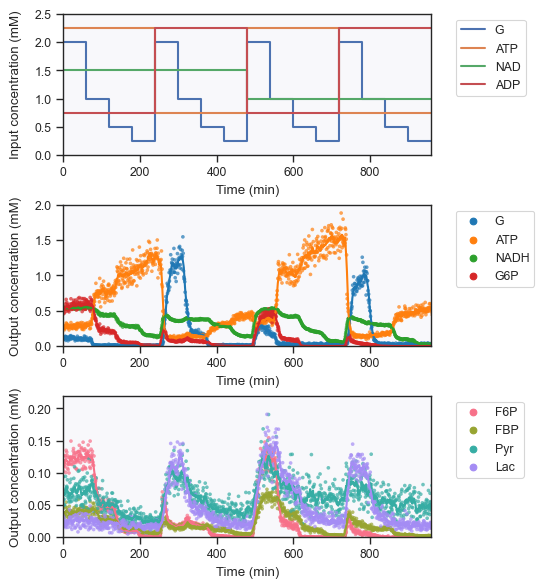

In [6]:
quantif_df1 = pd.DataFrame()
quantif_df2 = pd.DataFrame()

quantif_df1.index = sumdf.index
quantif_df2.index = sumdf.index

quantif_df1['G'] = (sumdf['L_G'] / sumdf['G'])*(G_concentration / sumdf["Flow ratio"])
quantif_df1['ATP'] = (sumdf['ATP_2+'] / sumdf['L_ATP_2+'])*(ATP_concentration / sumdf["Flow ratio"])
quantif_df1['NADH'] = (sumdf['NADH'] - NAD_2_13C_isotope*sumdf['NAD']) / 0.00302201 #Value determined in SNMS32 (see below)
quantif_df1['G6P'] = (sumdf['L_G6P'] / sumdf['G6P'])*(G6P_concentration / sumdf["Flow ratio"])
quantif_df2['F6P'] = ((sumdf['L_F6P'] - (FBPtoF6P*sumdf['L_FBP'])) / (sumdf['F6P'] - (FBPtoF6P*sumdf['FBP'])))*(F6P_concentration / sumdf["Flow ratio"]) #With FBP to F6P correction
quantif_df2['FBP'] = (sumdf['L_FBP'] / sumdf['FBP'])*(FBP_concentration / sumdf["Flow ratio"])
quantif_df2['Pyr'] = (sumdf['L_Pyr'] / sumdf['13C_Pyr'])*(Pyr_concentration / sumdf["Flow ratio"])
quantif_df2['Lac'] = ((sumdf['L_Lac'] - (GtoLac*sumdf['L_G'])) / (sumdf['Lac'] - (GtoLac*sumdf['G'])))*(Lac_concentration / sumdf["Flow ratio"]) #With correction of F to Lac fragmentation
quantif_df1.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0
quantif_df2.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

quantif_df1.index = quantif_df1.index / 60 #s to min
quantif_df1.index = quantif_df1.index - 90 #removing the first 90 minutes of equilibration
quantif_df2.index = quantif_df2.index / 60 #s to min
quantif_df2.index = quantif_df2.index - 90 #removing the first 90 minutes of equilibration

rolled_df1 = quantif_df1.rolling(10, center=True).mean()
rolled_df2 = quantif_df2.rolling(10, center=True).mean()

fig, ax = plt.subplots(3,1)

sns.lineplot(data = df_inputgraph, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="G", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ADP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ADP", palette="tab10")

sns.scatterplot(quantif_df1, alpha=0.7, ax=ax[1],  markers=["o"], s=7, palette="tab10", linewidth=0)
sns.lineplot(rolled_df1, dashes=False, alpha=1, ax=ax[1], linewidth=1.5, legend=None, palette="tab10")
sns.scatterplot(quantif_df2, alpha=0.7, ax=ax[2],  markers=["o"], s=7, palette="husl", linewidth=0)
sns.lineplot(rolled_df2, dashes=False, alpha=1, ax=ax[2], linewidth=1.5, legend=None, palette="husl")

ax[0].set_xlim(0,960)
ax[0].set_ylim(0,2.5)
ax[1].set_xlim(0,960)
ax[1].set_ylim(0,2)
ax[2].set_xlim(0,960)
ax[2].set_ylim(0,0.22)
ax[0].set_xlabel("Time (min)")
ax[0].set_ylabel("Input concentration (mM)")
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("Output concentration (mM)")
ax[2].set_xlabel("Time (min)")
ax[2].set_ylabel("Output concentration (mM)")

fig.align_ylabels(ax[:])
ax[0].set_facecolor('#F8F8FB')
ax[1].set_facecolor('#F8F8FB')
ax[2].set_facecolor('#F8F8FB')

ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplots_adjust(left=None, bottom=None, right=0.7, top=1.2, wspace=None, hspace=0.35)
#plt.savefig('SNMS32.png', format='png', bbox_inches='tight', dpi=600)

### Getting the intensities of the metabolites we do not quantify
#### Making Figure S3

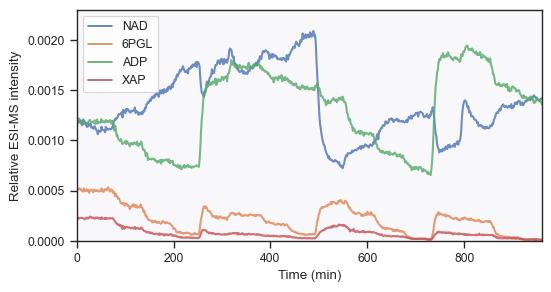

In [7]:
intensity_df = pd.DataFrame()
intensity_df.index = sumdf.index
intensity_df["NAD"] = sumdf["NAD"]
intensity_df["6PGL"] = sumdf["6PGL"]
intensity_df["ADP"] = sumdf["ADP"]
intensity_df["XAP"] = sumdf["L_GAP_DHAP"]

#binning
df_Time_Samp = intensity_df.groupby(intensity_df.index // TIMEBIN).min()
df_intensity_Samp =  intensity_df.groupby(intensity_df.index // TIMEBIN).mean()

df_intensity_Samp.index = (df_Time_Samp.index * TIMEBIN/60) - 90 #in minutes, minus the first 90 minutes of equilibration

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(df_intensity_Samp, dashes=False, alpha=0.8, linewidth=1.5)
ax.set_xlim(0,960)
ax.set_ylim(0,0.0023)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Relative ESI-MS intensity")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS32_SI_intensities.png', format='png', bbox_inches='tight', dpi=600)

### Estimation of the "observable conversion" of substrate in observable metabolites
#### Making Figure S6a

C:\Users\qduez\AppData\Local\Temp\ipykernel_6380\1252461072.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(conversion_all, alpha=0.8, s=7, palette="tab10", linewidth=0, label="G")


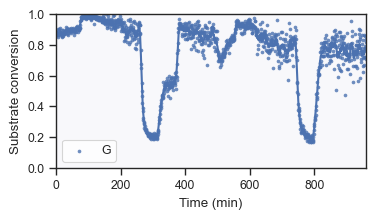

In [8]:
conversion_all = (quantif_df1['G6P'] + quantif_df2['F6P'] + quantif_df2['FBP'] + quantif_df2['Pyr'] + quantif_df2['Lac']) / (quantif_df1['G6P'] + quantif_df2['F6P'] + quantif_df2['FBP'] + quantif_df2['Pyr'] + quantif_df2['Lac'] + quantif_df1['G'])
rollingconv_all = conversion_all.rolling(10, center=True).mean()

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(conversion_all, alpha=0.8, s=7, palette="tab10", linewidth=0, label="G")
sns.lineplot(rollingconv_all, linewidth=1.5)

ax.set_xlim(0,960)
ax.set_ylim(0,1)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Substrate conversion")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS32_SI_conversion.png', format='png', bbox_inches='tight', dpi=600)

### Summing the concentration of observable metabolites
#### Making Figure S7a

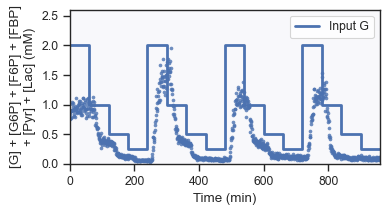

In [9]:
totaldf = pd.DataFrame()
totaldf = (quantif_df1['G'] + quantif_df1['G6P'] + quantif_df2['F6P'] + quantif_df2['FBP'] + quantif_df2['Pyr'] + quantif_df2['Lac'])

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(totaldf, alpha=0.8, legend=None, s=7, linewidth=0)
sns.lineplot(data = df_inputgraph, x="time", y="G", drawstyle='steps', alpha=1, linewidth=2, label='Input G')
ax.set_xlim(0,960)
ax.set_ylim(0,2.6)
ax.set_xlabel("Time (min)")
ax.set_ylabel("[G] + [G6P] + [F6P] + [FBP] + [Pyr] + [Lac] (mM)", wrap=True)
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS32_SI_summedconc.png', format='png', bbox_inches='tight', dpi=600)

### Estimation of the observation limit
#### Making Figure S5a
##### The observation limit is determined as the concentration associated with the background noise at the m/z of metabolites we do not observe (3PG and PEP for instance)

LOD is 0.022122862962194286 mM


C:\Users\qduez\AppData\Local\Temp\ipykernel_6380\3847989535.py:15: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(quantif_df3, alpha=0.5, s=7, markers=['o'], linewidth=0)


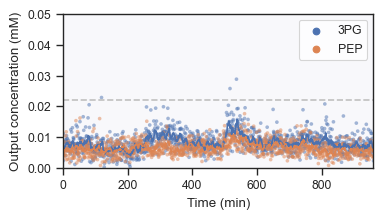

In [14]:
quantif_df3 = pd.DataFrame()
quantif_df3.index = sumdf.index
quantif_df3['3PG'] = (sumdf['L_3PG'] / sumdf['3PG'])*(PG_concentration/ sumdf["Flow ratio"])
quantif_df3['PEP'] = (sumdf['L_PEP'] / sumdf['PEP'])*(PEP_concentration/ sumdf["Flow ratio"])
LOD_3PG = quantif_df3['3PG'].mean() + 1.645*quantif_df3['3PG'].std()
LOD_PEP = quantif_df3['PEP'].mean() + 1.645*quantif_df3['PEP'].std()
LOD = (LOD_PEP + LOD_3PG)/2
print("LOD is " + str(LOD) + " mM")

quantif_df3.index = (quantif_df3.index/60)-90 #in minutes, minus the first 90 minutes of equilibration

rolled_df3 = quantif_df3.rolling(10, center=True).mean()

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(quantif_df3, alpha=0.5, s=7, markers=['o'], linewidth=0)
sns.lineplot(rolled_df3, legend=None)

ax.set_xlim(0,960)
ax.set_ylim(0,0.05)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Output concentration (mM)")
ax.axhline(LOD, c='silver', linestyle="--")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS32_SI_LOD.png', format='png', bbox_inches='tight', dpi=600)

### Establishing a relationship between UV absorbance readout and NADH ion intensities
#### Making Figure S29

The slope is [0.00302201]
The intercept is fixed at 0.0
R² = 0.979820828955038


Text(0.4, 0.00025, 'y = 0.00302.x \n  $R^²$ = 0.98')

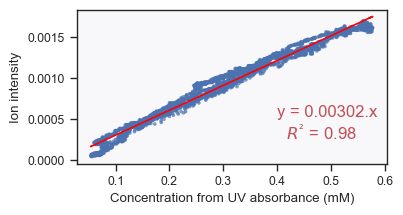

In [11]:
#NADH from UV
#Fitting between NADH intensity and UV concentrations
from sklearn import datasets, linear_model

NADH_df = pd.read_csv("data/SNMS32_UV.dat", header=8, delim_whitespace=True)
NADH_df.columns = ["StdTime", "Time", "Value"]
NADH_df.index = NADH_df["Time"] + 300 #Delay UV LABM8
NADH_df = NADH_df.drop(columns=["StdTime", "Time"])
NADH_df["Concentration"] = (4036-0.0156*NADH_df["Value"])*0.001 # mM - From UV cell calibration
NADH_df = NADH_df[(NADH_df.index > 5000) & (NADH_df.index < 63000)]

#The time scale of the UV readout and timstof are not exactly the same
#We need to interpolate the data and make both time scales uniform
desired_index = range(5100, 62900, 10)
NADH_df = NADH_df.reindex(NADH_df.index.union(desired_index)).interpolate(method='linear').reindex(desired_index)

NADH_intdf = pd.DataFrame()
NADH_intdf.index = sumdf.index
NADH_intdf["intensity"] = (sumdf["NADH"] - NAD_2_13C_isotope*sumdf["NAD"])
NADH_intdf = NADH_intdf[(NADH_intdf.index > 5000) & (NADH_intdf.index < 63000)]
NADH_intdf = NADH_intdf.reindex(NADH_intdf.index.union(desired_index)).interpolate(method='linear').reindex(desired_index)

comparedf = pd.DataFrame()
comparedf.index = NADH_df["Concentration"]
comparedf["intensity"] = NADH_intdf["intensity"].values

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(comparedf, s=7, legend=None, linewidth=0, alpha=0.7)

x = comparedf.index.values
y = comparedf["intensity"].values
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)

plt.plot(x, regr.predict(x), c='red')
ax.set_xlabel("Concentration from UV absorbance (mM)")
ax.set_ylabel("Ion intensity")
ax.set_facecolor('#F8F8FB')

print("The slope is " + str(regr.coef_[0]))
print("The intercept is fixed at " + str(regr.intercept_))
print("R² = " + str(regr.score(x,y)))
plt.text(0.4, 0.00025, 'y = 0.00302.x \n  $R^²$ = 0.98', fontsize=12, c='r')
#plt.savefig('SNMS32_SI_UVabsorbance.png', format='png', bbox_inches='tight', dpi=600)

### Comparison between NADH concentrations from UV readout and ion intensities
#### Making Figure S30a

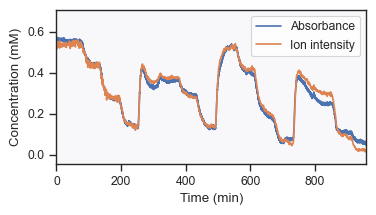

In [12]:
#Validation - UV
NADH_df = pd.read_csv("data/SNMS32_UV.dat", header=8, delim_whitespace=True)
NADH_df.columns = ["StdTime", "Time", "Value"]
NADH_df.index = NADH_df["Time"] + 300 #Delay UV and syringe pumps
NADH_df = NADH_df.drop(columns=["StdTime", "Time"])
NADH_df["Concentration"] = (4007.8-0.0155*NADH_df["Value"])*0.001 # mM - From UV cell calibration

NADH_intdf = pd.DataFrame()
NADH_intdf.index = sumdf.index
NADH_intdf["intensity"] = (sumdf["NADH"] - NAD_2_13C_isotope*sumdf["NAD"])
NADH_intdf["Concentration"] = NADH_intdf["intensity"] / 0.00302201

NADH_df.index = (NADH_df.index/60)-90 #in minutes, minus the first 90 minutes of equilibration
NADH_intdf.index = (NADH_intdf.index/60)-90 #in minutes, minus the first 90 minutes of equilibration

fig, ax = plt.subplots(figsize=(4, 2))
sns.lineplot(NADH_df, x="Time", y="Concentration", label="Absorbance")
sns.lineplot(NADH_intdf, x=NADH_intdf.index, y="Concentration", label="Ion intensity")
ax.set_xlim(0, 960)
#ax.set_ylim(0, 0.7)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Concentration (mM)")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS32_SI_NADHConc_fromUVabsorbance.png', format='png', bbox_inches='tight', dpi=600)

#### Making Figure S30b

R² is 0.9794134239514195


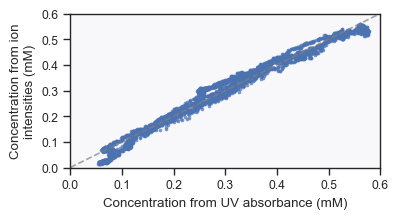

In [18]:
comparedf["Conc_fromint"] = comparedf["intensity"] / 0.00302201

x_th = np.linspace(0, 1, 100)
y_th = x_th

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(data=comparedf, x=comparedf.index, y="Conc_fromint", alpha=0.7, s=7, linewidth=0)
plt.plot(x_th,y_th, c='grey', linestyle='--', alpha=0.7)
ax.set_xlabel("Concentration from UV absorbance (mM)")
ax.set_ylabel("Concentration from ion intensities (mM)", wrap=True)
ax.set_facecolor('#F8F8FB')
ax.set_xlim(0.0, 0.6)
ax.set_ylim(0.0, 0.6)

#plt.savefig('SNMS32_SI_Comparison_conc_UV_ionint.png', format='png', bbox_inches='tight', dpi=600)